# **RANDOM FOREST CLASSIFIER**

### **PREPROCESS THE DATASET**

In [28]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [29]:
# Load the dataset and replace placeholder '?' with NaN
df = pd.read_csv("student_depression_dataset.csv")

In [30]:
# Drop irrelevant/high-cardinality columns
df = df.drop(columns=['id', 'City', 'Profession'])
print(f"Data Shape After Dropping Columns: {df.shape}")

Data Shape After Dropping Columns: (27901, 15)


**Handling missing values**

In [31]:
# Handle missing values (Imputation)
df['Financial Stress'] = df['Financial Stress'].replace('?', np.nan).astype(float)
df['Work/Study Hours'] = df['Work/Study Hours'].replace('?', np.nan)
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

if df['Financial Stress'].isna().any() or df['Work/Study Hours'].isna().any():
    df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].median())
    df['Work/Study Hours'] = df['Work/Study Hours'].fillna(df['Work/Study Hours'].median())
    print('Step 3: Missing values handled with median imputation.')

Step 3: Missing values handled with median imputation.


In [32]:
# Rename target variable for clarity
df = df.rename(columns={'Depression': 'Depression_Target'})
print('Step 4: Target variable renamed.')


Step 4: Target variable renamed.


**Outlier removal**

In [33]:
# Outlier Removal Preparation
# Identify numerical columns
numerical_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Define the outlier detection function (using IQR method)
def detect_outliers_iqr(df_in, column):
    """Calculates the IQR fences for a column."""
    Q1 = df_in[column].quantile(0.25)
    Q3 = df_in[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Outlier Removal (Applied to df_cleaned)
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

for col in numerical_cols:
    lower, upper = detect_outliers_iqr(df_cleaned, col)
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]

rows_removed = initial_rows - len(df_cleaned)
print(f"\nTotal rows after outlier removal: {len(df_cleaned)}")



Total rows after outlier removal: 27878


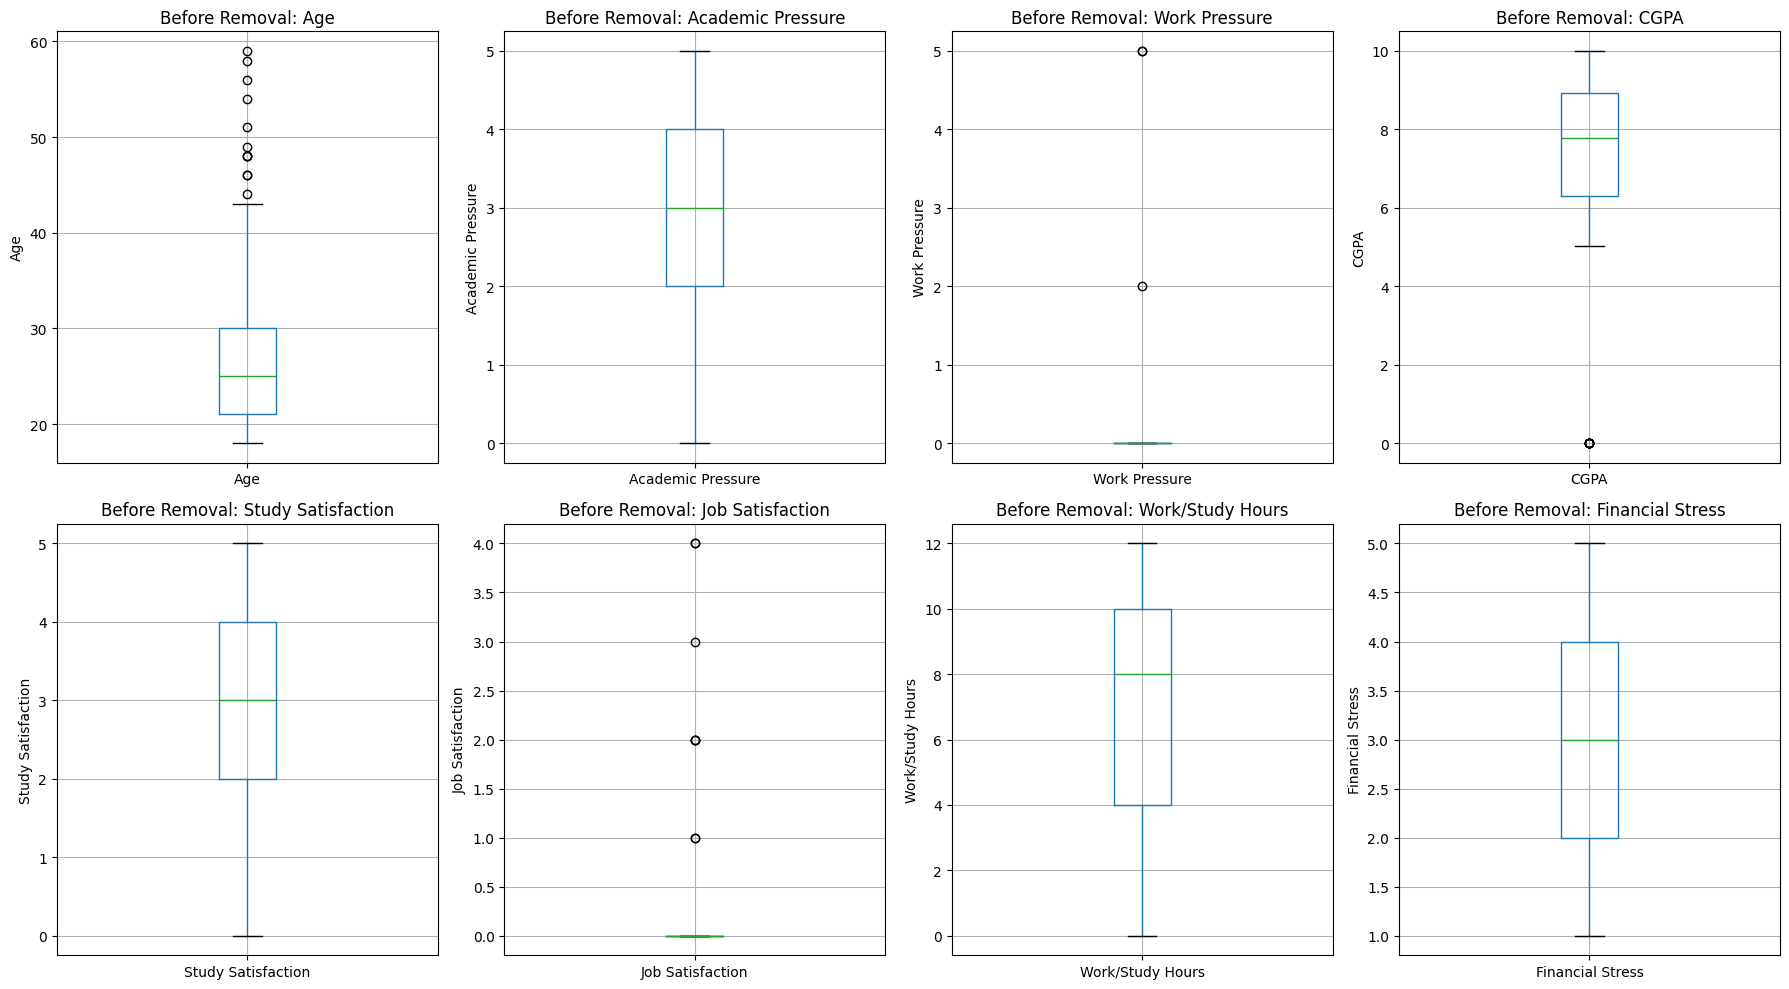

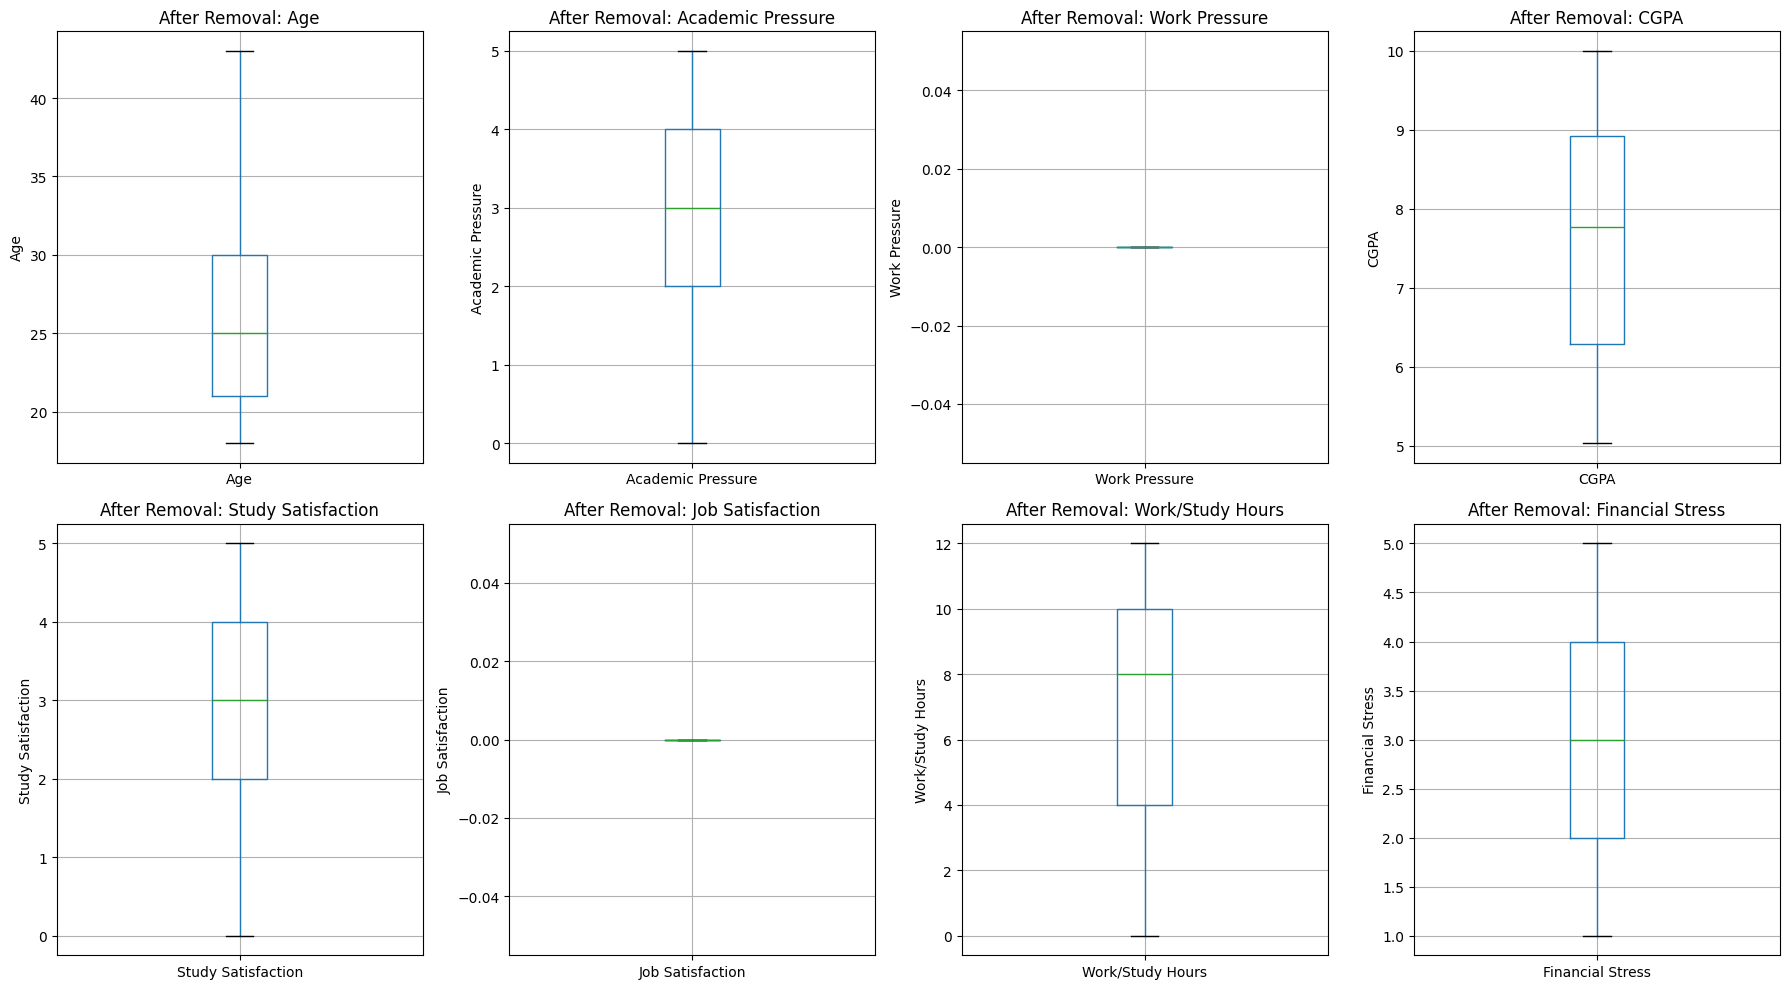

In [34]:

# Box Plots BEFORE Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df.boxplot(column=col)
    plt.title(f'Before Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_before_outlier_removal.png')
plt.close()

# Box Plots AFTER Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df_cleaned.boxplot(column=col)
    plt.title(f'After Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_after_outlier_removal.png')
plt.close()


**Encoding categorical data**

In [35]:
# --- Encoding Categorical Variables on CLEANED data ---
df_encoded = df_cleaned.copy()

# Binary Encoding and dropping original columns
binary_mapping = {
    'Gender': {'Male': 0, 'Female': 1},
    'Have you ever had suicidal thoughts ?': {'No': 0, 'Yes': 1},
    'Family History of Mental Illness': {'No': 0, 'Yes': 1}
}
binary_cols_to_drop = []

for original_col, mapping in binary_mapping.items():
    encoded_col = original_col.replace(' ', '_').replace('?', '').strip() + '_Encoded'
    if original_col in df_encoded.columns:
        # Impute NaNs in original column with mode before mapping
        df_encoded[original_col] = df_encoded[original_col].fillna(df_encoded[original_col].mode()[0])
        df_encoded[encoded_col] = df_encoded[original_col].map(mapping)
        binary_cols_to_drop.append(original_col)

df_encoded = df_encoded.drop(columns=binary_cols_to_drop)
print('Binary categorical variables encoded and original columns dropped.')


# One-Hot Encoding
categorical_cols = ['Degree', 'Sleep Duration', 'Dietary Habits']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, dtype=int)
print('Nominal categorical variables one-hot encoded.')

# Save the encoded data for the feature selection step
df_encoded.to_csv('student_depression_dataset_encoded.csv', index=False)

Binary categorical variables encoded and original columns dropped.
Nominal categorical variables one-hot encoded.


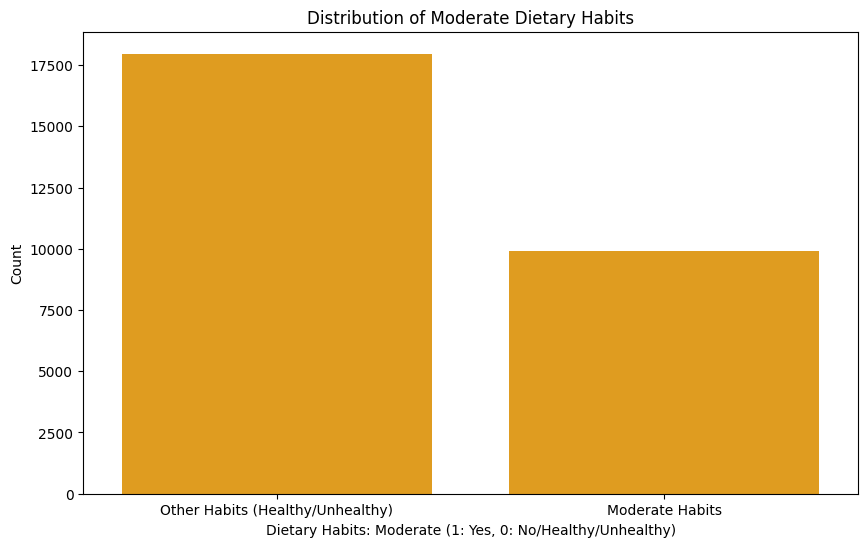

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create bar chart
plt.figure(figsize=(10, 6))
# Use one of your one-hot encoded columns, e.g., 'Dietary Habits_Moderate'
sns.countplot(x='Dietary Habits_Moderate', data=df_encoded, color='orange')
plt.title('Distribution of Moderate Dietary Habits')
plt.xlabel('Dietary Habits: Moderate (1: Yes, 0: No/Healthy/Unhealthy)')
plt.ylabel('Count')
# Customize labels for readability
plt.xticks(ticks=[0, 1], labels=['Other Habits (Healthy/Unhealthy)', 'Moderate Habits'])
plt.savefig('moderate_diet_distribution.png', dpi=300)
plt.show()
plt.close()

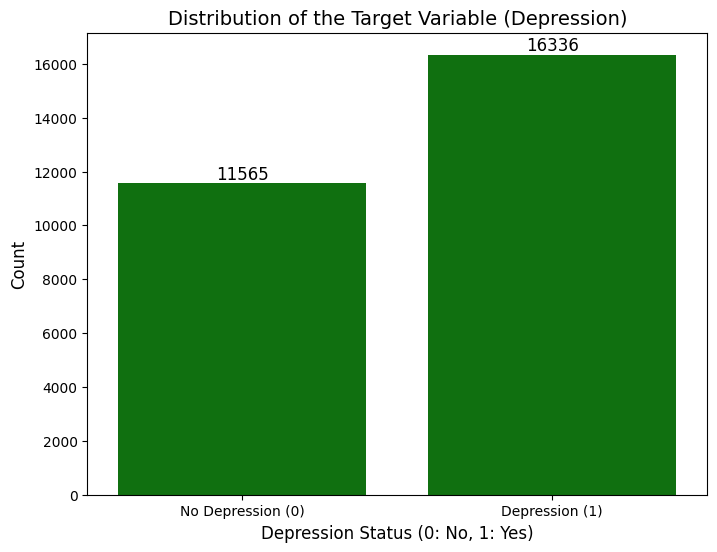

In [37]:
# Create the countplot for the 'Depression' target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Depression_Target', data=df, color='green')
plt.title('Distribution of the Target Variable (Depression)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set custom x-tick labels for clarity
plt.xticks(ticks=[0, 1], labels=['No Depression (0)', 'Depression (1)'])

# Add counts on top of bars for exact numbers (optional but helpful)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.savefig('target_distribution.png', dpi=300)
plt.show()
plt.close()

In [38]:
display(df_encoded)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression_Target,Gender_Encoded,...,Degree_MSc,Degree_Others,Degree_PhD,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours',Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy
0,33.0,5.0,0.0,8.97,2.0,0.0,3.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,24.0,2.0,0.0,5.90,5.0,0.0,3.0,2.0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,31.0,3.0,0.0,7.03,5.0,0.0,9.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,28.0,3.0,0.0,5.59,2.0,0.0,4.0,5.0,1,1,...,0,0,0,1,0,0,0,1,0,0
4,25.0,4.0,0.0,8.13,3.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,27.0,5.0,0.0,5.75,5.0,0.0,7.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
27897,27.0,2.0,0.0,9.40,3.0,0.0,0.0,3.0,0,0,...,1,0,0,0,1,0,0,0,0,0
27898,31.0,3.0,0.0,6.61,4.0,0.0,12.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
27899,18.0,5.0,0.0,6.88,2.0,0.0,10.0,5.0,1,1,...,0,0,0,0,1,0,0,0,0,0


**Feature selection using ANOVA F-test**

In [39]:
# Load the processed and encoded data
df_encoded = pd.read_csv('student_depression_dataset_encoded.csv')

# Define the target column name
target_col = 'Depression_Target'

# Prepare data for feature selection
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- CORRECTION: Add VarianceThreshold for Robustness ---
# Remove features with zero variance (prevents error in f_classif)
vt_selector = VarianceThreshold()
X_vt = vt_selector.fit_transform(X)
cols_after_vt = X.columns[vt_selector.get_support()]
X_vt = pd.DataFrame(X_vt, columns=cols_after_vt, index=X.index)


# Rerun Feature selection using ANOVA F-test (SelectKBest)
top_k = 10
selector = SelectKBest(score_func=f_classif, k=top_k)

# Fit the selector to the variance-filtered data
selector.fit(X_vt, y)

# Get F-scores and feature ranking
f_scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X_vt.columns, 'F_score': f_scores}).sort_values(
    by='F_score', ascending=False
)

# Print the top features and scores
print("\n--- Feature Ranking (ANOVA F-Score) ---")
print(feature_scores.head(top_k + 5).to_markdown(index=False))

# Select and Filter the DataFrame
selected_features = feature_scores['Feature'].head(top_k).tolist()
df_reduced = df_encoded[selected_features + [target_col]].copy()

print(f"\nTop {top_k} Selected Features: {selected_features}")
print(f"Reduced DataFrame shape: {df_reduced.shape}")

# Save the reduced DataFrame
df_reduced.to_csv('student_depression_dataset_feature_selection.csv', index=False)
print("Saved: student_depression_dataset_feature_selection.csv")


--- Feature Ranking (ANOVA F-Score) ---
| Feature                                      |    F_score |
|:---------------------------------------------|-----------:|
| Have_you_ever_had_suicidal_thoughts__Encoded | 11870.2    |
| Academic Pressure                            |  8123.75   |
| Financial Stress                             |  4256.14   |
| Age                                          |  1495.94   |
| Work/Study Hours                             |  1266.06   |
| Dietary Habits_Unhealthy                     |  1039.45   |
| Study Satisfaction                           |   810.921  |
| Sleep Duration_'More than 8 hours'           |   185.824  |
| Sleep Duration_'Less than 5 hours'           |   173.764  |
| Family_History_of_Mental_Illness_Encoded     |    80.2698 |
| Dietary Habits_Moderate                      |    40.8136 |
| Degree_M.Tech                                |    25.2384 |
| Degree_M.Ed                                  |    22.0953 |
| CGPA                       

**Balancing the dataset**

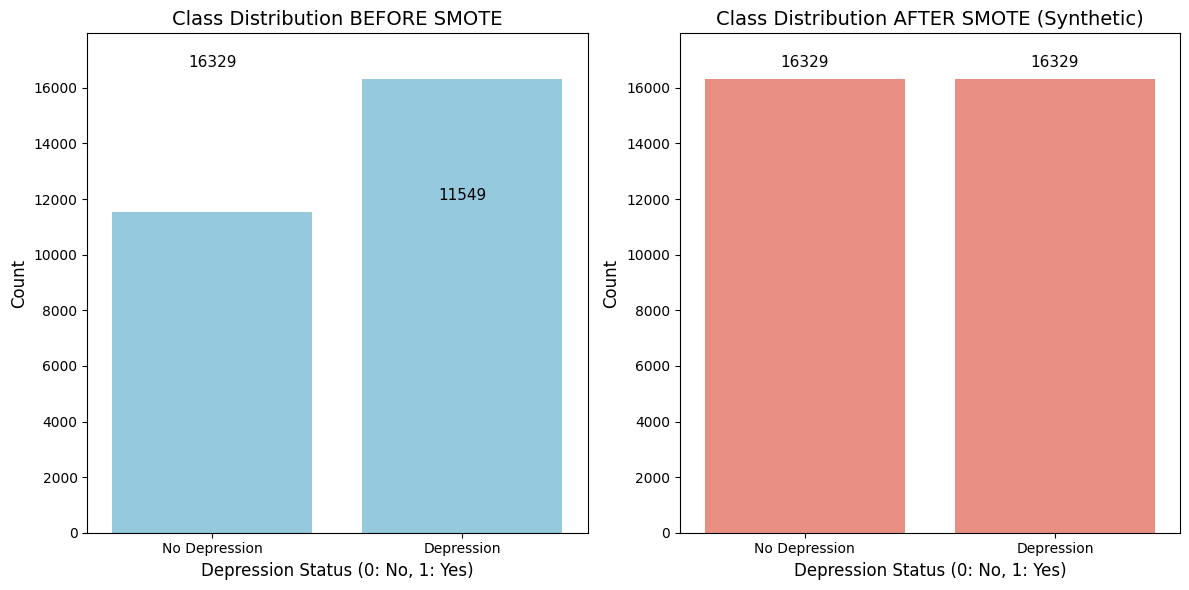

In [40]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define the target column name
target_col = 'Depression_Target'

# --- 1. Load Unbalanced Data (Before SMOTE) ---
# This file contains the feature-selected data, which is unbalanced.
df_unbalanced = pd.read_csv('student_depression_dataset_feature_selection.csv')
y_unbalanced = df_unbalanced[target_col] # Renamed for clarity
data_before = y_unbalanced.value_counts()

# --- 2. Load Balanced Data (After SMOTE) ---
# This file is assumed to be generated by the SMOTE code you ran previously.
df_balanced = pd.read_csv('student_depression_dataset_balanced.csv')
data_after = df_balanced[target_col].value_counts()

# Determine the maximum count for consistent y-axis scaling
max_count = max(data_before.max(), data_after.max())

# --- 3. Visualization Code ---

# Create Comparison Visualization
plt.figure(figsize=(12, 6))

# Subplot 1: Before SMOTE
plt.subplot(1, 2, 1)
sns.barplot(x=data_before.index, y=data_before.values, color='skyblue')
plt.title('Class Distribution BEFORE SMOTE', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1) # Set Y-axis limit

# Add counts on top of bars
for i, count in enumerate(data_before.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11)

# Subplot 2: After SMOTE
plt.subplot(1, 2, 2)
sns.barplot(x=data_after.index, y=data_after.values, color='salmon')
plt.title('Class Distribution AFTER SMOTE (Synthetic)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1) # Set Y-axis limit

# Add counts on top of bars
for i, count in enumerate(data_after.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('SMOTE_Class_Distribution_Comparison.png', dpi=300)
plt.show()

### **TRAIN THE MODEL**

In [41]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import joblib

# Define target column
target_col = 'Depression_Target'

# Load the BALANCED, feature-selected dataset
df_balanced = pd.read_csv("student_depression_dataset_balanced.csv")
print(f"Dataset shape: {df_balanced.shape}")
print(f"Class Distribution:\n{df_balanced[target_col].value_counts()}")

Dataset shape: (32658, 11)
Class Distribution:
Depression_Target
1    16329
0    16329
Name: count, dtype: int64


**Split the data into test set & train set**

In [42]:
# Separate features (X) and target (y)
X = df_balanced.drop(target_col, axis=1)
y = df_balanced[target_col]

# Split into train and test sets (80% train, 20% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**Train the model**

In [43]:
# Train Baseline Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    random_state=42
)

print("\nTraining Baseline Model on BALANCED Data...")
rf_model.fit(X_train, y_train)


Training Baseline Model on BALANCED Data...


RandomForestClassifier(random_state=42)

In [44]:
# Predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

**Model evaluation**


Model Accuracy (Baseline, Balanced Data): 0.8575

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      3266
           1       0.86      0.86      0.86      3266

    accuracy                           0.86      6532
   macro avg       0.86      0.86      0.86      6532
weighted avg       0.86      0.86      0.86      6532



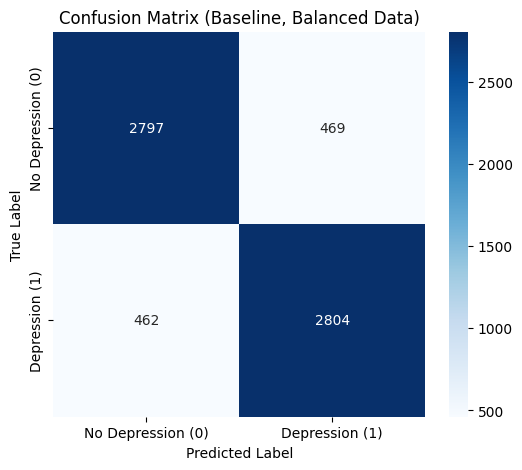

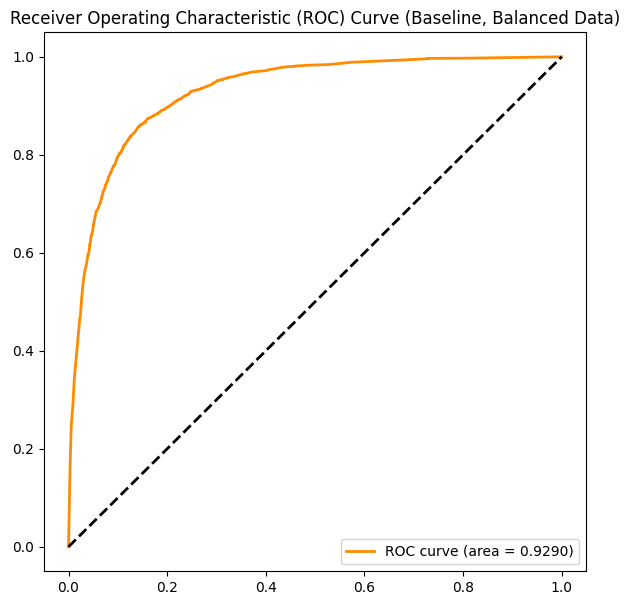

In [45]:
# --- Evaluation ---
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nModel Accuracy (Baseline, Balanced Data): {accuracy:.4f}")
print("\nClassification Report:\n", class_report)

# Save the trained model
joblib.dump(rf_model, 'random_forest_baseline_balanced_model.joblib')


# Plot Confusion Matrix (for visualization)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Depression (0)', 'Depression (1)'],
            yticklabels=['No Depression (0)', 'Depression (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Baseline, Balanced Data)')
plt.savefig('confusion_matrix_balanced_baseline.png')
plt.show()
plt.close()

# Plot ROC Curve (for visualization)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(7, 7))
plt.plot(false_positive_rate, true_positive_rate,
         label=f'ROC curve (area = {roc_auc:.4f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('Receiver Operating Characteristic (ROC) Curve (Baseline, Balanced Data)')
plt.legend(loc="lower right")
plt.savefig('roc_curve_balanced_baseline.png')
plt.show()
plt.close()


In [46]:
joblib.dump(rf_model, "random_forest_model.pkl")
print(" Model saved as random_forest_model.pkl")

 Model saved as random_forest_model.pkl


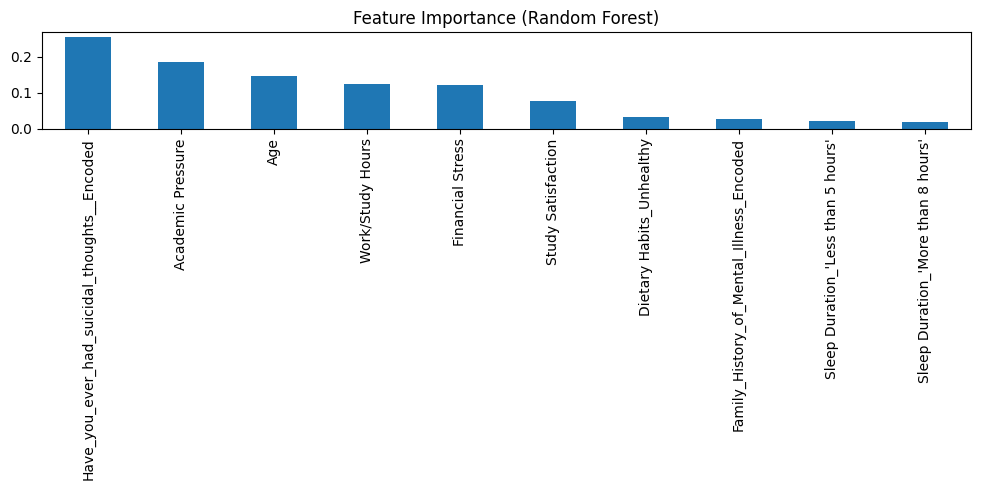

In [47]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

### **HYPERPARAMETER TUNING USING GridSearchCV**

### **& validate using cross-validation**

In [48]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: X_train, X_test, y_train, y_test are used directly from the split in Section 1.

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV (using F1-score as the metric for balanced data)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model on the BALANCED training data
print("\nRunning Grid Search on BALANCED data for final model...")
grid_search.fit(X_train, y_train)

# Display best parameters
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate Tuned Model
y_pred_best = best_rf_model.predict(X_test)
y_proba_best = best_rf_model.predict_proba(X_test)[:, 1]

# Classification Report
print("\n Classification Report (Tuned Model on BALANCED DATA):")
print(classification_report(y_test, y_pred_best))

# Save final tuned model
joblib.dump(best_rf_model, "random_forest_best_balanced_model.pkl")
print("\n Tuned model saved as random_forest_best_balanced_model.pkl")


Running Grid Search on BALANCED data for final model...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best Hyperparameters Found:
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

 Classification Report (Tuned Model on BALANCED DATA):
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3266
           1       0.86      0.87      0.86      3266

    accuracy                           0.86      6532
   macro avg       0.86      0.86      0.86      6532
weighted avg       0.86      0.86      0.86      6532


 Tuned model saved as random_forest_best_balanced_model.pkl


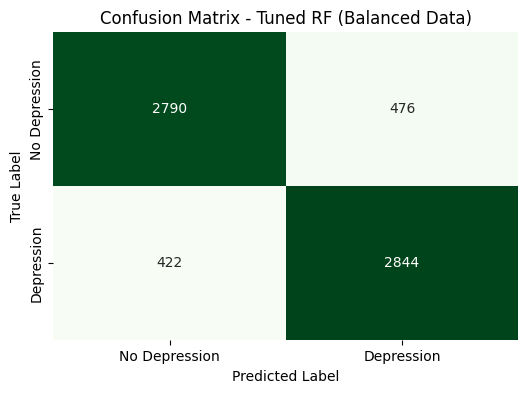

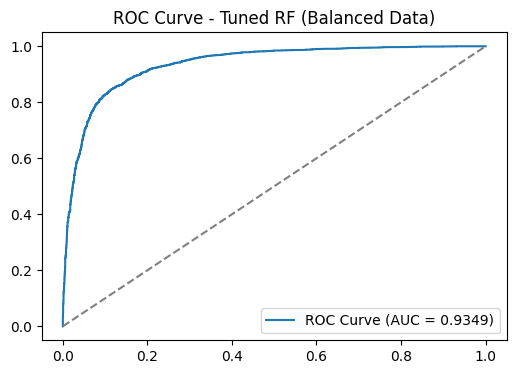

In [49]:
# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'])
plt.title("Confusion Matrix - Tuned RF (Balanced Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("tuned_confusion_matrix_balanced.png")
plt.show()
plt.close()

# ROC Curve
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(6,4))
plt.plot(fpr_best, tpr_best, label=f"ROC Curve (AUC = {roc_auc_best:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve - Tuned RF (Balanced Data)")
plt.legend()
plt.savefig("tuned_roc_curve_balanced.png")
plt.show()
plt.close()

### **Learning curve**

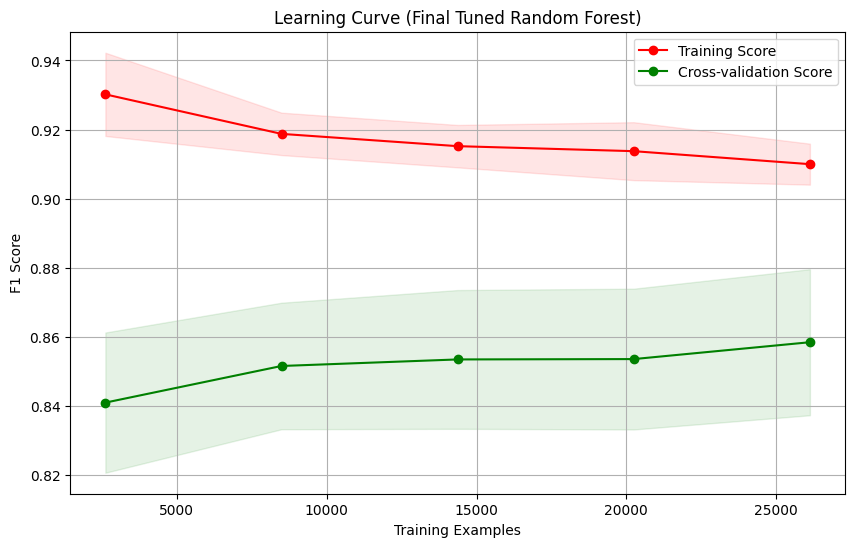

In [52]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc
)
import joblib


# Generate Learning Curve Data
# Use the optimal model for the learning curve. Scoring is F1-score as used in tuning.
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5), scoring='f1'
)

# Calculate mean and standard deviation for plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Plotting the Learning Curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve (Final Tuned Random Forest)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.grid()

# Plot training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")

# Plot cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")

plt.legend(loc="best")
plt.savefig('model_learning_curve.png')
plt.show()

### **COMPARE PERFORMANCE**


 Model Performance Comparison:
            Model  Accuracy  AUC Score
0   Base RF Model  0.857471   0.929015
1  Tuned RF Model  0.862523   0.934924


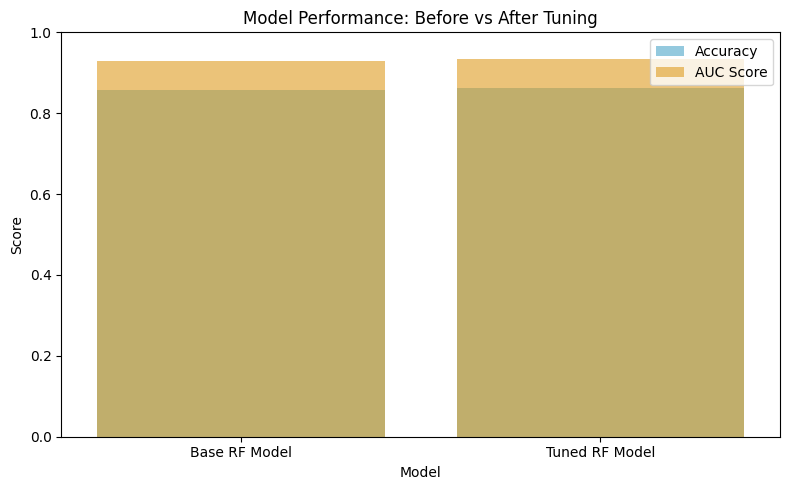

In [53]:
# Compare Performance
# Collect metrics
# Calculate accuracy for the tuned model
best_accuracy = accuracy_score(y_test, y_pred_best)

metrics = {
    "Model": ["Base RF Model", "Tuned RF Model"],
    "Accuracy": [accuracy, best_accuracy],
    "AUC Score": [roc_auc, roc_auc_best]
}

comparison_df = pd.DataFrame(metrics)

# Display the comparison table
print("\n Model Performance Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=comparison_df, color="skyblue", label="Accuracy")
sns.barplot(x="Model", y="AUC Score", data=comparison_df, color="orange", alpha=0.6, label="AUC Score")

plt.title("Model Performance: Before vs After Tuning")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

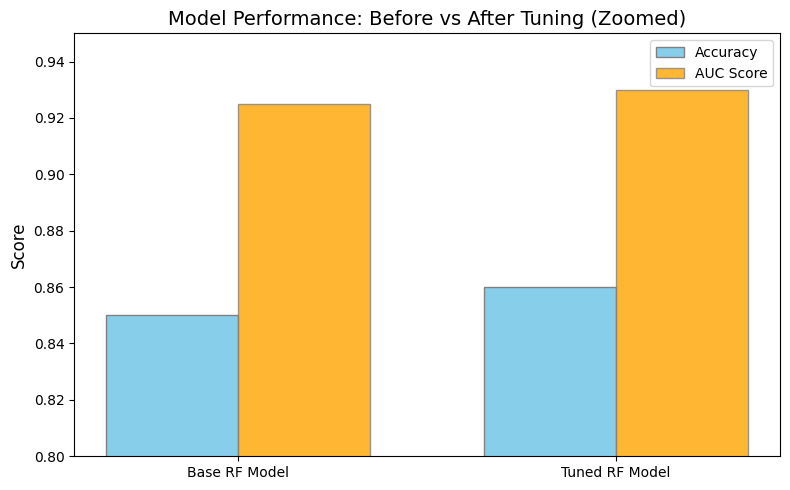

In [54]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics based on your results
metrics = {
    "Model": ["Base RF Model", "Tuned RF Model"],
    "Accuracy": [0.85, 0.86], # Use your exact final numbers
    "AUC Score": [0.9250, 0.9300] # Use your exact final numbers
}

comparison_df = pd.DataFrame(metrics)

# Plot comparison with ZOOMED Y-AXIS
plt.figure(figsize=(8,5))
bar_width = 0.35
r1 = np.arange(len(comparison_df['Model']))
r2 = [x + bar_width for x in r1]

plt.bar(r1, comparison_df['Accuracy'], color='skyblue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, comparison_df['AUC Score'], color='orange', width=bar_width, edgecolor='grey', alpha=0.8, label='AUC Score')

plt.xticks([r + bar_width/2 for r in r1], comparison_df['Model'])
plt.title("Model Performance: Before vs After Tuning (Zoomed)", fontsize=14)

# --- CRITICAL FIX: ZOOM IN THE Y-AXIS ---
plt.ylim(0.80, 0.95)
# ----------------------------------------

plt.ylabel("Score", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show() # In your notebook, use plt.savefig('zoomed_comparison.png')

### **TEST THE MODEL ON UNSEEN DATA**

### **Load the model & check accuracy again**

In [55]:
# Import Libraries
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define file names
target_col = 'Depression_Target'
model_file = "random_forest_best_balanced_model.pkl"
data_file = "student_depression_dataset_balanced.csv" # MUST be the balanced data

# Load Data (to recreate the exact test split)
df = pd.read_csv(data_file)
X = df.drop(target_col, axis=1)
y = df[target_col]

# Recreate the Test Set (Crucial: use the same random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load the tuned model
model = joblib.load(model_file)
print("Model loaded successfully!")

# Predict on Test Data
y_pred_loaded = model.predict(X_test)

# Calculate Accuracy
loaded_accuracy = accuracy_score(y_test, y_pred_loaded)

# Output final confirmation
print(f"\n Loaded Model Accuracy (Must match 0.86): {loaded_accuracy:.4f}")
print("-" * 50)

Model loaded successfully!

 Loaded Model Accuracy (Must match 0.86): 0.8625
--------------------------------------------------


In [56]:
# Load the best model (using the same file name)
model = joblib.load("random_forest_best_balanced_model.pkl")

# Define the list of feature columns based on the training data (from X_test)
# You need to define these again if you run this code in a fresh session:
FEATURE_COLUMNS = [
    'Academic Pressure', 'Financial Stress', 'Age', 'Work/Study Hours',
    'Study Satisfaction', 'CGPA', 'Have_you_ever_had_suicidal_thoughts__Encoded',
    'Dietary Habits_Unhealthy', "Sleep Duration_'More than 8 hours'",
    "Sleep Duration_'Less than 5 hours'", 'Family_History_of_Mental_Illness_Encoded',
    'Dietary Habits_Moderate', "Sleep Duration_'7-8 hours'",
    'Gender_Encoded'
] # Note: Use the exact feature list from your final X columns here.
  # If you used the top 10 features, adjust this list accordingly.

# Based on the feature selection step (Top 10):
FEATURE_COLUMNS = [
    'Have_you_ever_had_suicidal_thoughts__Encoded', 'Academic Pressure',
    'Financial Stress', 'Age', 'Work/Study Hours', 'Dietary Habits_Unhealthy',
    'Study Satisfaction', "Sleep Duration_'More than 8 hours'",
    "Sleep Duration_'Less than 5 hours'", 'Family_History_of_Mental_Illness_Encoded'
]


### **Predict on unseen data**

### **Test 1**

In [57]:
# --- A. Test with a Single New Patient ---

# Data for one new student:
new_patient_data = {
    'Have_you_ever_had_suicidal_thoughts__Encoded': [1],  # (1 = Yes)
    'Academic Pressure': [4.5],                          # (e.g., High Pressure)
    'Financial Stress': [4.0],                           # (e.g., High Stress)
    'Age': [23.0],
    'Work/Study Hours': [10.0],                          # (e.g., High hours)
    'Dietary Habits_Unhealthy': [1],                     # (1 = Unhealthy)
    'Study Satisfaction': [1.0],                         # (e.g., Low Satisfaction)
    "Sleep Duration_'More than 8 hours'": [0],         # (0 = No)
    "Sleep Duration_'Less than 5 hours'": [1],           # (1 = Yes)
    'Family_History_of_Mental_Illness_Encoded': [1]      # (1 = Yes)
}

# Create DataFrame and ensure columns are in the correct order
new_patient = pd.DataFrame(new_patient_data)[FEATURE_COLUMNS]

# Predict the class (0 or 1) and probability
pred = model.predict(new_patient)
prob = model.predict_proba(new_patient)[0][1] # Probability of Class 1 (Depression)

if pred[0] == 1:
    print(f"The model predicts:  DEPRESSION (Probability: {prob:.4f})")
else:
    print(f"The model predicts:  NO DEPRESSION (Probability: {prob:.4f})")

The model predicts:  DEPRESSION (Probability: 0.9527)


### **Test 2**

In [58]:
# --- B. Test with a Single New Patient ---

# Data for one new student:
new_patient_data = {
    'Have_you_ever_had_suicidal_thoughts__Encoded': [0],  # (1 = Yes)
    'Academic Pressure': [2],                          # (e.g., High Pressure)
    'Financial Stress': [3.0],                           # (e.g., High Stress)
    'Age': [22.0],
    'Work/Study Hours': [20.0],                          # (e.g., High hours)
    'Dietary Habits_Unhealthy': [0],                     # (1 = Unhealthy)
    'Study Satisfaction': [5.0],                         # (e.g., Low Satisfaction)
    "Sleep Duration_'More than 8 hours'": [0],         # (0 = No)
    "Sleep Duration_'Less than 5 hours'": [0],           # (1 = Yes)
    'Family_History_of_Mental_Illness_Encoded': [0]      # (1 = Yes)
}

# Create DataFrame and ensure columns are in the correct order
new_patient = pd.DataFrame(new_patient_data)[FEATURE_COLUMNS]

# Predict the class (0 or 1) and probability
pred = model.predict(new_patient)
prob = model.predict_proba(new_patient)[0][1] # Probability of Class 1 (Depression)

if pred[0] == 1:
    print(f"The model predicts:  DEPRESSION (Probability: {prob:.4f})")
else:
    print(f"The model predicts:  NO DEPRESSION (Probability: {prob:.4f})")

The model predicts:  NO DEPRESSION (Probability: 0.0633)


### **Test 3**

In [59]:
# --- C. Test with Multiple Patients at Once ---

# Data for two patients (must align with FEATURE_COLUMNS order!):
new_patients_data = [
    # Patient 1: Low Risk Example (All low risk factors)
    [0, 1.0, 5, 20.0, 3.0, 0, 5.0, 0, 0, 0],
    # Patient 2: High Risk Example (High risk factors)
    [1, 5.0, 1, 30.0, 9.0, 1, 1.0, 0, 1, 1]
]

new_patients_df = pd.DataFrame(new_patients_data, columns=FEATURE_COLUMNS)

# Predict classes for both
predictions = model.predict(new_patients_df)
probabilities = model.predict_proba(new_patients_df)[:, 1]

for i, (p, prob) in enumerate(zip(predictions, probabilities)):
    status = "DEPRESSION " if p == 1 else "NO DEPRESSION "
    print(f"Patient {i+1}: {status} (Prob: {prob:.4f})")

Patient 1: NO DEPRESSION  (Prob: 0.0341)
Patient 2: DEPRESSION  (Prob: 0.8800)
